#### Solving Helmholtz Equation using Physically Informed Kolmogorov-Arnold Networks

This notebook presents a methodology for solving the following equation:

$$ \frac{d^2 u(x)}{d^2 x}  + k^2 u(x)= f(x)\quad \forall x \in (0, 1)$$ 
 
With $$k = 1$$      

and the boundary conditions:
$$y(0) = 0 \quad y(1) = 0$$

Activate venv .\env\Scripts\activate


In [1]:
from kan import *
from torch.autograd import grad
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create a KAN: 1D inputs, 1D output, grid 3 and spline degree 3
model = KAN(width=[1,3,3,3,1], grid=3, k=3, seed=42, device=device)
model.to(device)  # Move the model to the selected device

cuda
checkpoint directory created: ./model
saving model version 0.0


MultKAN(
  (act_fun): ModuleList(
    (0-3): 4 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-3): 4 x Symbolic_KANLayer()
  )
)

In [2]:
style = "ggplot"

In [3]:
def compute_integral(y, x):    
    integral = torch.trapz(y, x, dim=0)
    return integral


def exact_u_prime(x):
    #return 2*x - torch.pi
    return -(torch.sin(torch.tensor(0.5))/torch.cos(torch.tensor(0.5))) * torch.cos(x) + torch.sin(x) 

def compute_errors(model, x, exact_u, N):
    exact_function = exact_u(x)
    predicted_function = model(x)
    
    error_between_functions = exact_function - predicted_function
    error_squared = error_between_functions**2

    L2_error = 1/(N) *(compute_integral(error_squared, x))**0.5

    return torch.sqrt(L2_error).item()

In [4]:
def train(model, optimizer, loss_fn, f, n_pts, iterations):
    losses = []
    # Use tqdm to track progress
    len = 0
    L2_errors = []
    for iteration in tqdm(range(iterations), desc="Training", total=iterations):  
        optimizer.zero_grad()
        x = torch.FloatTensor(n_pts,1).uniform_(0, 1).requires_grad_(True).to(device)  # Move x to the correct device
        loss = loss_fn(model, x, f)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())


        x = torch.linspace(0, 1, n_pts)        
        x = x.requires_grad_(True).view(n_pts, 1).to(device)            
        L2_error = compute_errors(model, x, exact_u,n_pts)
        L2_errors.append(L2_error) 

        if iteration % 10 == 0:
            tqdm.write(f'Iteration {iteration}, Loss {loss.item()}')  # Print progress at regular intervals
            #x_test = torch.linspace(0, 1, n_pts).view(n_pts, 1) 

            xlist = np.linspace(0, 1, n_pts)
            xlist_torch = torch.tensor(xlist, dtype=torch.float32, requires_grad=True).view(-1, 1).to(device)

            u_ap = model(xlist_torch)
            u_ex = exact_u(xlist_torch)

            # Move back to CPU for numpy operations if needed
            u_ap = u_ap.cpu().detach().numpy()
            u_ex = u_ex.cpu().detach().numpy()
            with plt.style.context(style):        

                fig, ax = plt.subplots()
                plt.plot(xlist, u_ap)
                plt.plot(xlist, u_ex, ".", markevery=15)
                plt.title('Approximation of a function using PIKANS (Iteration: ' +str(iteration) +')')

                plt.legend(['Aproximación', 'Exacta'])
                plt.xlabel("x")
                plt.ylabel("u(x)")
                ax.legend(['Approximate Solution', 'Exact Solution'])

                name = 'a'*(len)
                len += 1
                plt.savefig("figures_Kan/iter"+name+".png", dpi=300, bbox_inches='tight')
                #plt.show()
  

    with plt.style.context(style):        
        fig, ax = plt.subplots(figsize=(10, 4))
        
        ax.loglog(losses, label="Loss function on a PIKAN")

        # Graficar el error L2 en escala semilog en la misma gráfica
        ax.loglog(L2_errors, label="$L^2$ error of the approximation")       

        ax.set_title("Loss function and error while training a PIKAN", fontsize="x-large")
        ax.set_xlabel("Loss", fontsize="x-large")  # Etiqueta del eje x

        # Configurar los títulos y etiquetas    
        ax.set_xlabel("Iteration", fontsize="x-large")  # Cambiar a "x-large"        
        ax.legend(fontsize="large")

        # Ajustar el layout y mostrar la figura
        plt.tight_layout()
        plt.savefig('KAN_RESULT.pdf', dpi=300, bbox_inches='tight')
        plt.show()
    
    x_test = torch.linspace(0, 1, n_pts).view(n_pts, 1)
    return losses


def residual(u, x, f):
    du = grad(u, x, grad_outputs=torch.ones_like(u).to(device), create_graph=True)[0]
    ddu = grad(du, x, grad_outputs=torch.ones_like(du).to(device), create_graph=True)[0]
    return ddu + u - f(x)

def loss_fn(u_model, x, f):
    u = u_model(x)
    res = residual(u, x, f)
    res_MSE = torch.mean(res**2)
    bc = u_model(torch.tensor([[1.0]], device=device))**2 + u_model(torch.tensor([[0.0]], device=device))**2
    return res_MSE + bc[0] 
"""
def f_rhs(x):
    return torch.sin(torch.pi*x)

def exact_u(x):
    return (1/(1-torch.pi**2))*torch.sin(torch.pi*x)
"""

def f_rhs(x):
  return(0.*x + 1)
  #return(torch.tensor(1.0))
  #return 0.*x-2. #4*torch.sin(2 * x) # #
  

def exact_u(x):
  #return x*(x-torch.pi) # #torch.sin(2 * x) #
  return -(torch.sin(torch.tensor(0.5))/torch.cos(torch.tensor(0.5))) * torch.sin(x) - torch.cos(x) + 1


In [5]:
n_pts = 1000
iterations = 500
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Numpar = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(Numpar)



288


Training:   0%|          | 0/500 [00:00<?, ?it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:176

Iteration 0, Loss 1.1007204142076916


Training:   0%|          | 1/500 [00:03<28:09,  3.39s/it]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps

Iteration 10, Loss 0.6894773042543912


Training:   2%|▏         | 11/500 [00:08<04:33,  1.79it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOp

Iteration 20, Loss 0.5055211166165718


Training:   4%|▍         | 21/500 [00:12<03:40,  2.18it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOp

Iteration 30, Loss 0.17508667479115766


Training:   6%|▌         | 31/500 [00:17<04:40,  1.67it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOp

Iteration 40, Loss 0.02869951036901858


Training:   8%|▊         | 41/500 [00:21<03:49,  2.00it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOp

Iteration 50, Loss 0.01992514213470404


Training:  10%|█         | 51/500 [00:25<03:24,  2.20it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOp

Iteration 60, Loss 0.004617260937232128


Training:  12%|█▏        | 61/500 [00:29<03:17,  2.23it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOp

Iteration 70, Loss 0.0030450195405413013


Training:  14%|█▍        | 71/500 [00:33<03:11,  2.24it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOp

Iteration 80, Loss 0.0009316118620866654


Training:  16%|█▌        | 81/500 [00:36<03:11,  2.18it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOp

Iteration 90, Loss 0.0007131453891839069


Training:  18%|█▊        | 91/500 [00:40<03:06,  2.19it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOp

Iteration 100, Loss 0.00048788611451311035


Training:  20%|██        | 101/500 [00:44<02:57,  2.25it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 110, Loss 0.0004486498713420372


Training:  22%|██▏       | 111/500 [00:49<05:09,  1.26it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 120, Loss 0.0003641040542689062


Training:  24%|██▍       | 121/500 [00:54<03:39,  1.73it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 130, Loss 0.00032597036246941415


Training:  26%|██▌       | 131/500 [00:58<02:59,  2.05it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 140, Loss 0.0003036298359398231


Training:  28%|██▊       | 141/500 [01:02<02:44,  2.19it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 150, Loss 0.0002640553765654308


Training:  30%|███       | 151/500 [01:06<02:39,  2.19it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 160, Loss 0.00022426856098727051


Training:  32%|███▏      | 161/500 [01:11<03:00,  1.87it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 170, Loss 0.00022723592245666336


Training:  34%|███▍      | 171/500 [01:15<02:52,  1.90it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 180, Loss 0.00021259148298875065


Training:  36%|███▌      | 181/500 [01:20<02:41,  1.98it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 190, Loss 0.0001853673132563296


Training:  38%|███▊      | 191/500 [01:24<02:28,  2.09it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 200, Loss 0.00017213372160758555


Training:  40%|████      | 201/500 [01:28<02:29,  2.00it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 210, Loss 0.0001684735222063263


Training:  42%|████▏     | 211/500 [01:32<02:12,  2.18it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 220, Loss 0.00014492892420605251


Training:  44%|████▍     | 221/500 [01:36<02:07,  2.19it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 230, Loss 0.00016675295709106002


Training:  46%|████▌     | 231/500 [01:40<02:03,  2.17it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 240, Loss 0.00015468206859300176


Training:  48%|████▊     | 241/500 [01:44<02:00,  2.15it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 250, Loss 0.0001402918836684434


Training:  50%|█████     | 251/500 [01:48<01:53,  2.20it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 260, Loss 0.00013959756576506076


Training:  52%|█████▏    | 261/500 [01:52<01:50,  2.17it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 270, Loss 0.00012577065908130379


Training:  54%|█████▍    | 271/500 [01:56<01:44,  2.19it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 280, Loss 0.00012708794797967112


Training:  56%|█████▌    | 281/500 [02:00<01:41,  2.16it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 290, Loss 0.00010778560999704646


Training:  58%|█████▊    | 291/500 [02:04<01:34,  2.21it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 300, Loss 0.00010578157506595508


Training:  60%|██████    | 301/500 [02:08<01:55,  1.72it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 310, Loss 0.00010919195876801929


Training:  62%|██████▏   | 311/500 [02:14<02:06,  1.50it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 320, Loss 0.00010619688482348343


Training:  64%|██████▍   | 321/500 [02:18<01:26,  2.06it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 330, Loss 0.00011276903665266555


Training:  66%|██████▌   | 331/500 [02:22<01:18,  2.14it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 340, Loss 0.00010502230414548354


Training:  68%|██████▊   | 341/500 [02:26<01:14,  2.14it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 350, Loss 9.3947852983682e-05


Training:  70%|███████   | 351/500 [02:30<01:09,  2.14it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 360, Loss 9.92557525567929e-05


Training:  72%|███████▏  | 361/500 [02:34<01:03,  2.18it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 370, Loss 9.443501008046024e-05


Training:  74%|███████▍  | 371/500 [02:38<00:59,  2.18it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 380, Loss 9.623332150481894e-05


Training:  76%|███████▌  | 381/500 [02:42<00:53,  2.24it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 390, Loss 9.16460968168804e-05


Training:  78%|███████▊  | 391/500 [02:47<01:13,  1.48it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 400, Loss 9.399737072577546e-05


Training:  80%|████████  | 401/500 [02:55<01:14,  1.33it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 410, Loss 9.018577960717986e-05


Training:  82%|████████▏ | 411/500 [03:00<00:49,  1.81it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 420, Loss 8.791973520063287e-05


Training:  84%|████████▍ | 421/500 [03:04<00:36,  2.14it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 430, Loss 8.63454496147145e-05


Training:  86%|████████▌ | 431/500 [03:09<00:39,  1.77it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 440, Loss 7.867557151455092e-05


Training:  88%|████████▊ | 441/500 [03:14<00:34,  1.74it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 450, Loss 7.989180505536785e-05


Training:  90%|█████████ | 451/500 [03:18<00:23,  2.10it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 460, Loss 7.836663041439929e-05


Training:  92%|█████████▏| 461/500 [03:22<00:18,  2.06it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 470, Loss 6.772902806786626e-05


Training:  94%|█████████▍| 471/500 [03:26<00:12,  2.24it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 480, Loss 7.451225768168375e-05


Training:  96%|█████████▌| 481/500 [03:30<00:08,  2.15it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

Iteration 490, Loss 7.286687582957393e-05


Training:  98%|█████████▊| 491/500 [03:34<00:03,  2.28it/s]c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\greg2\Desktop\pyk_gpu\pykan-master\kan\MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceO

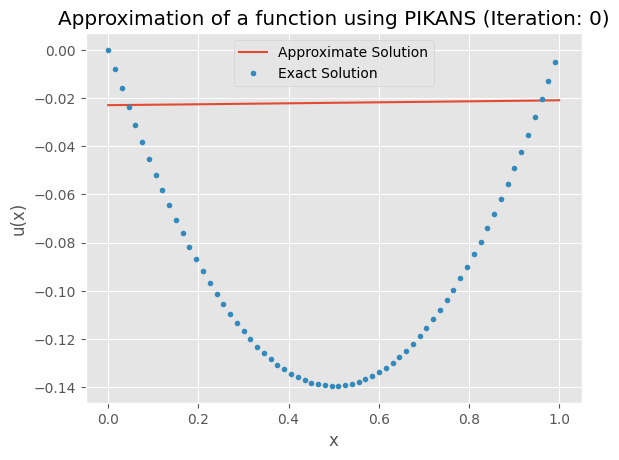

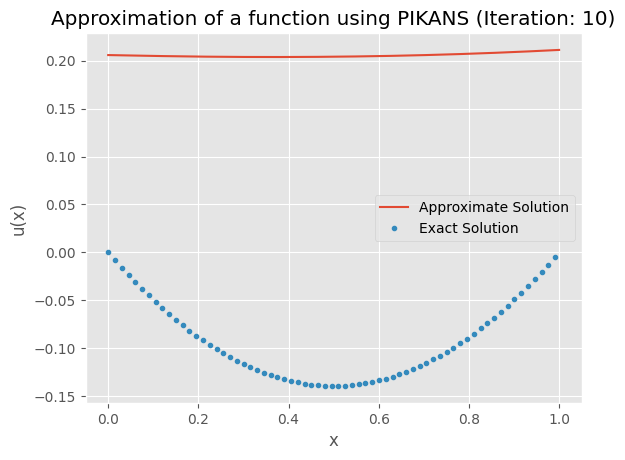

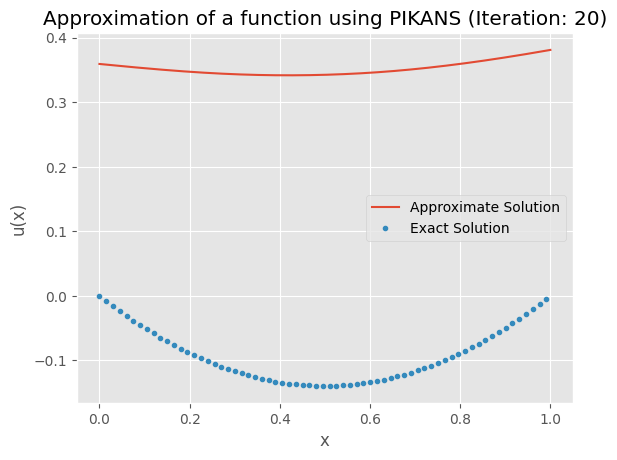

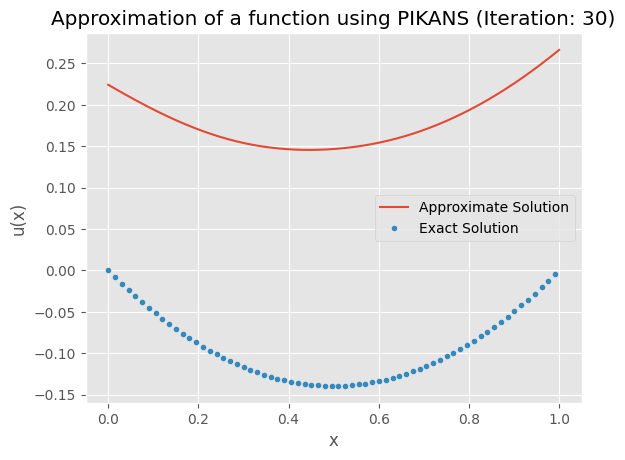

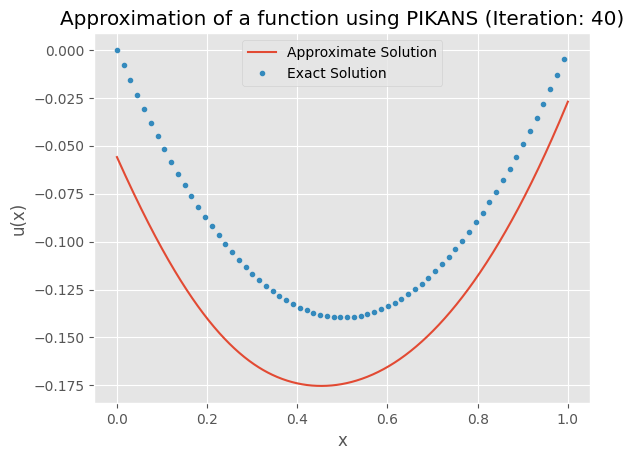

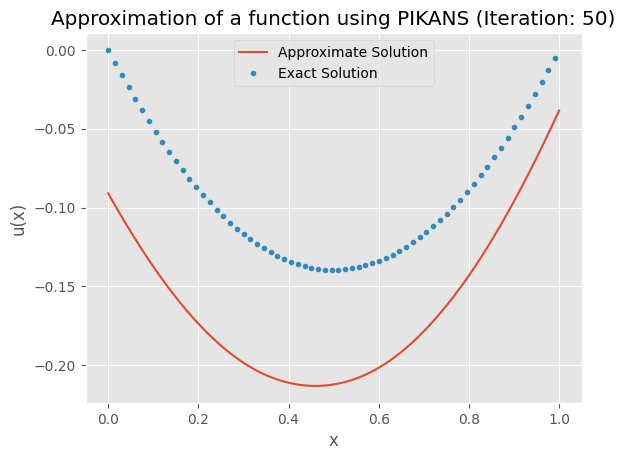

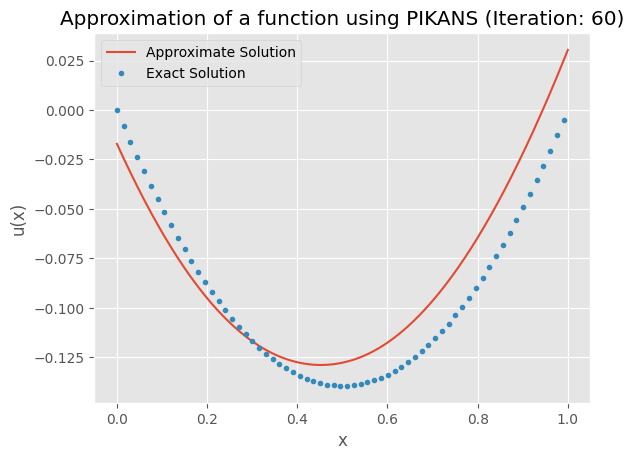

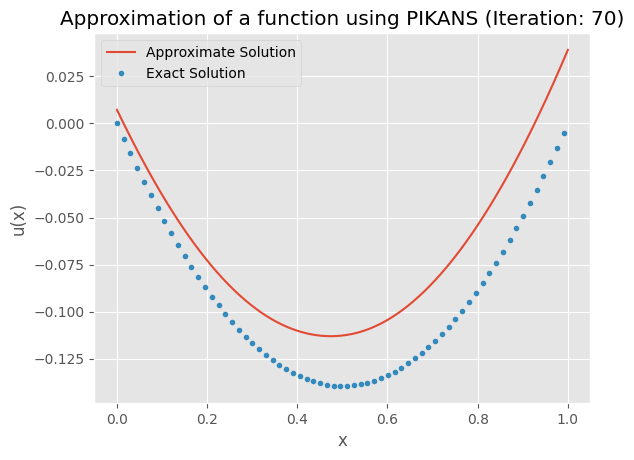

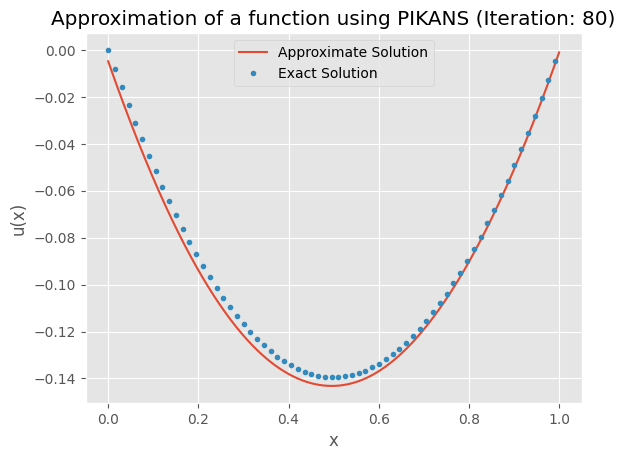

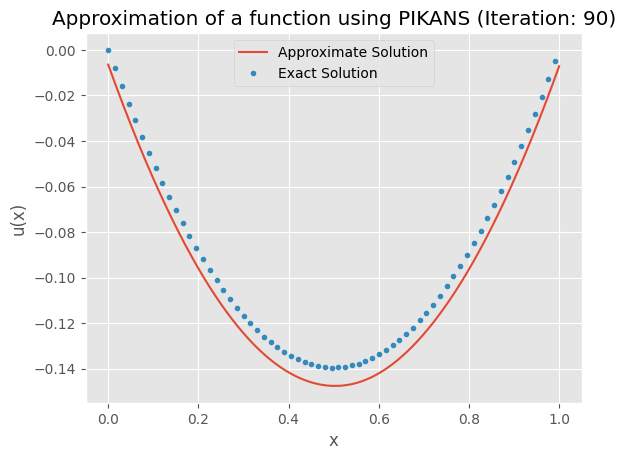

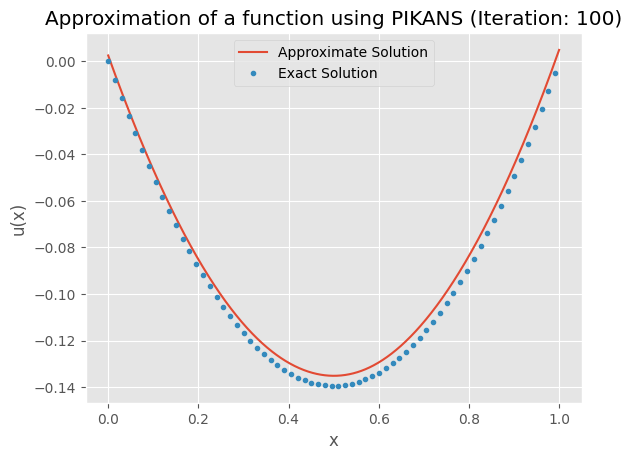

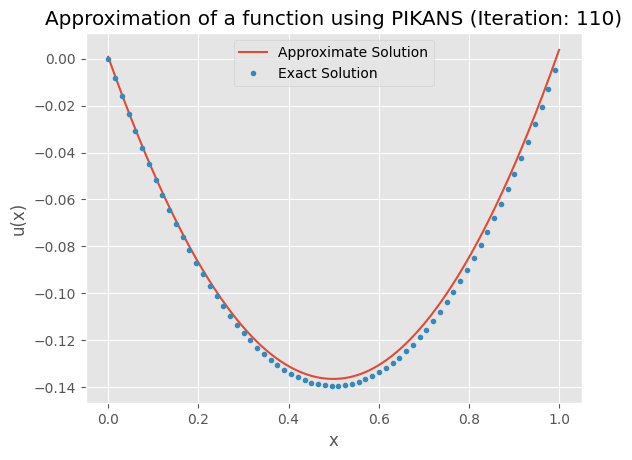

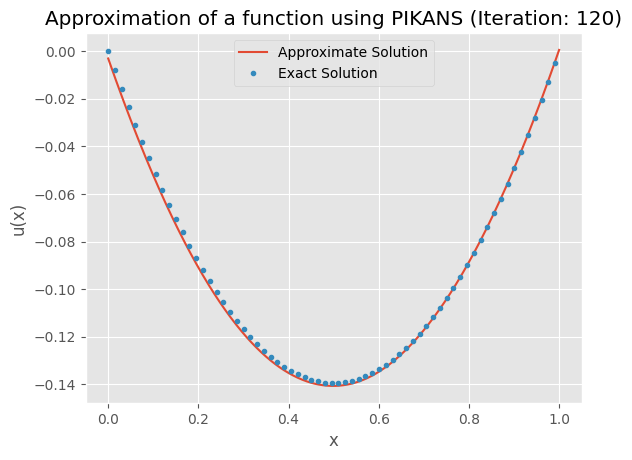

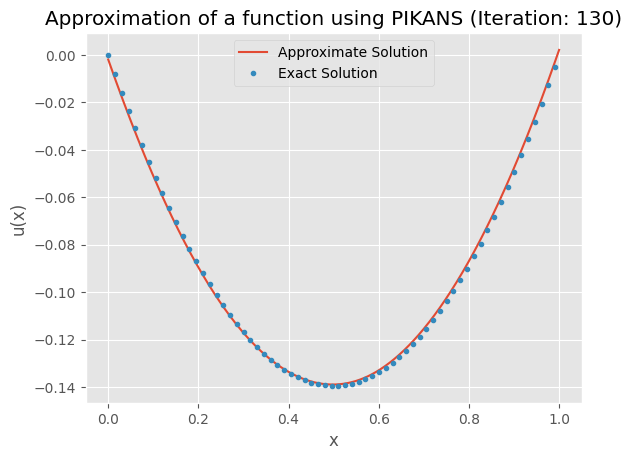

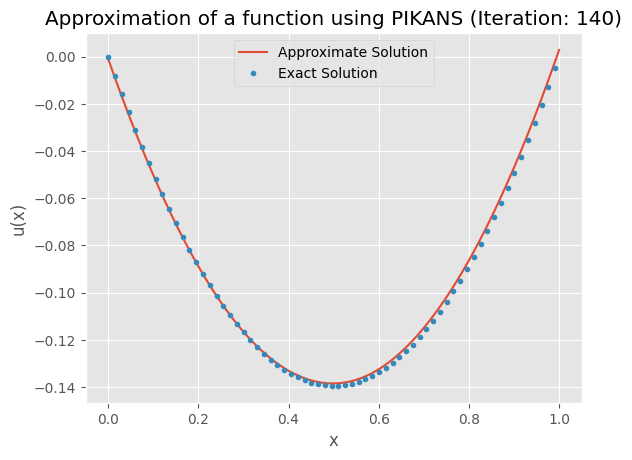

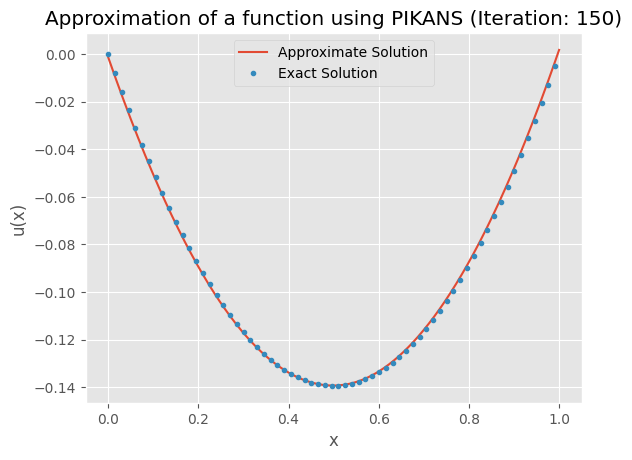

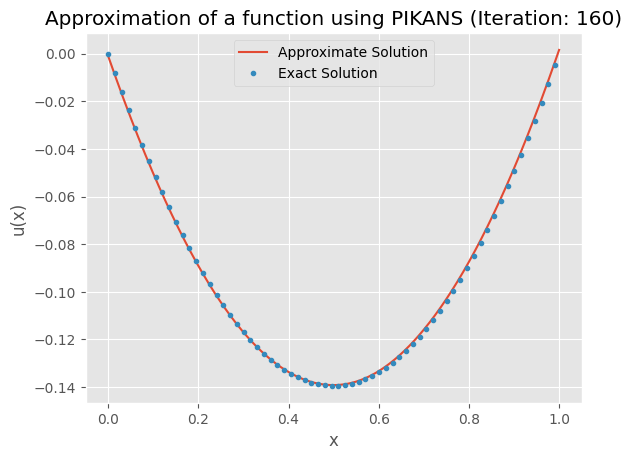

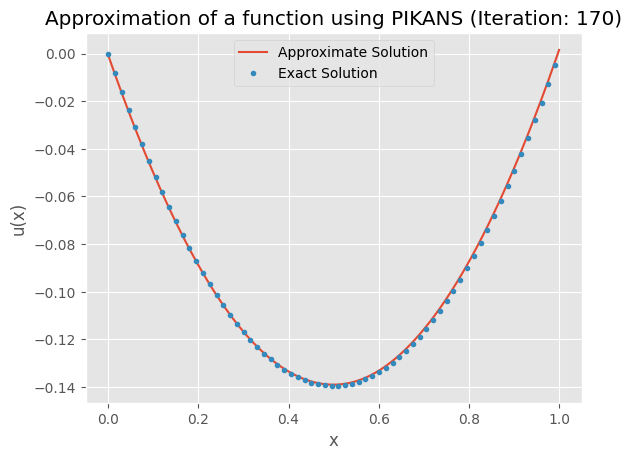

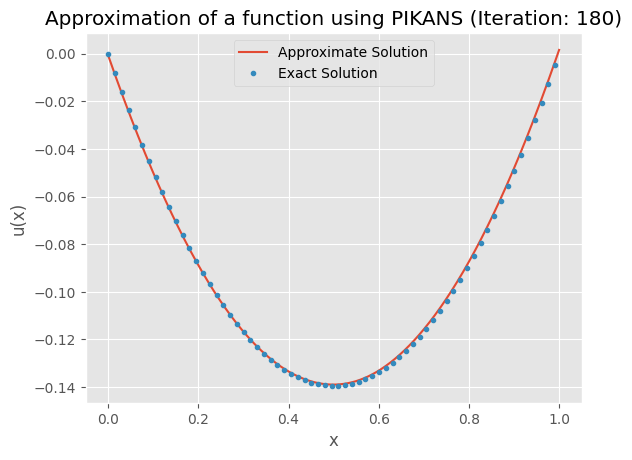

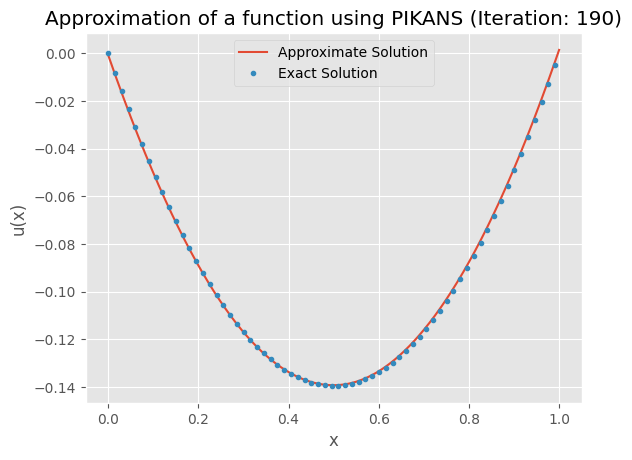

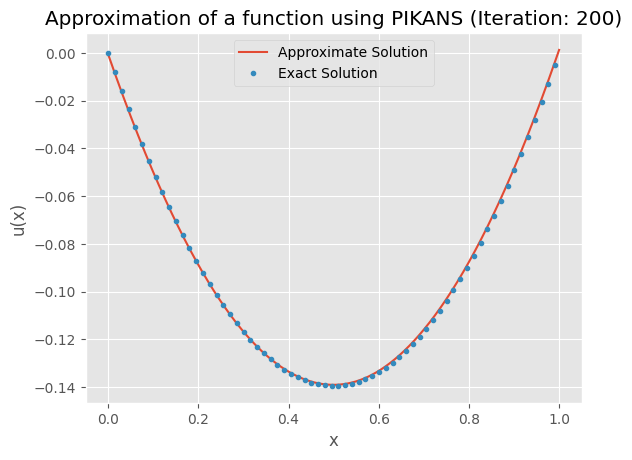

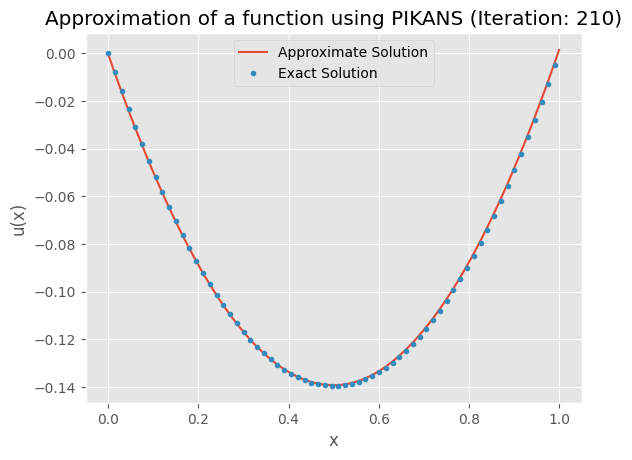

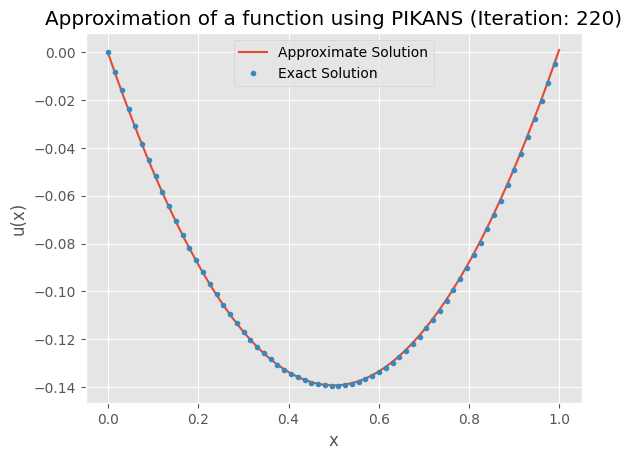

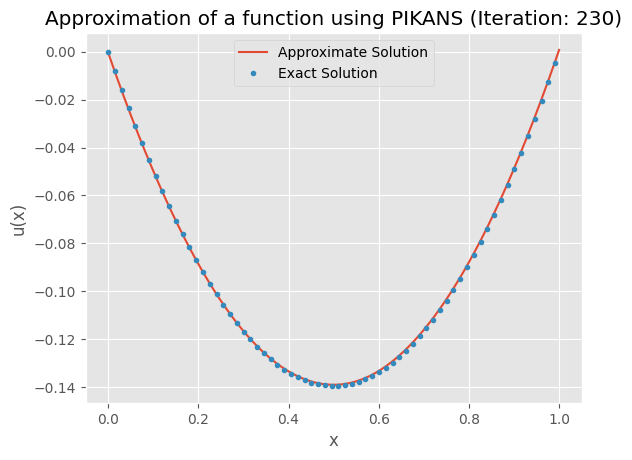

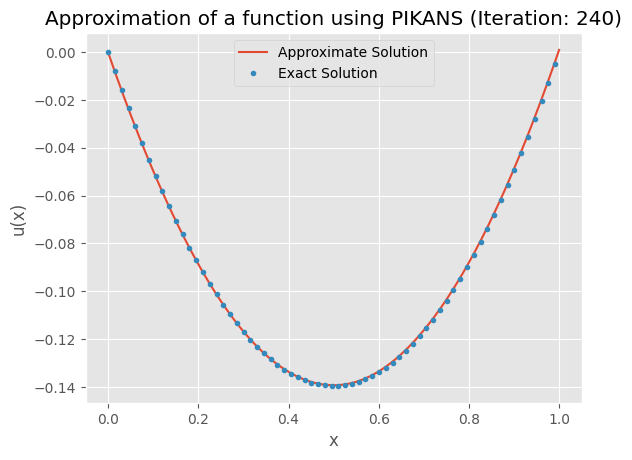

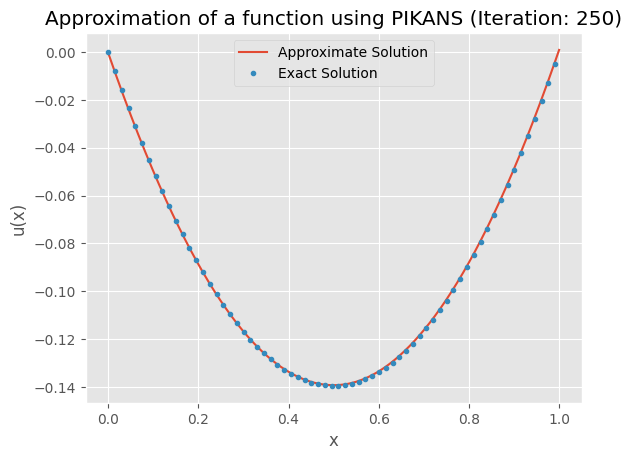

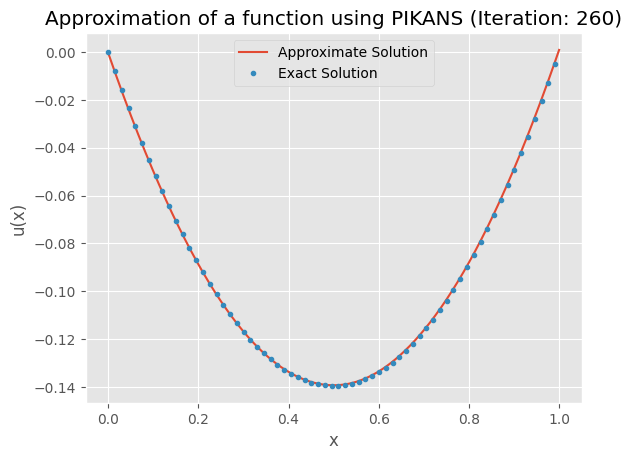

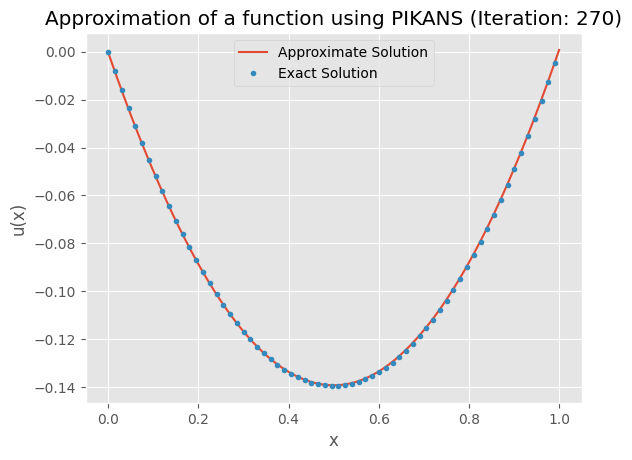

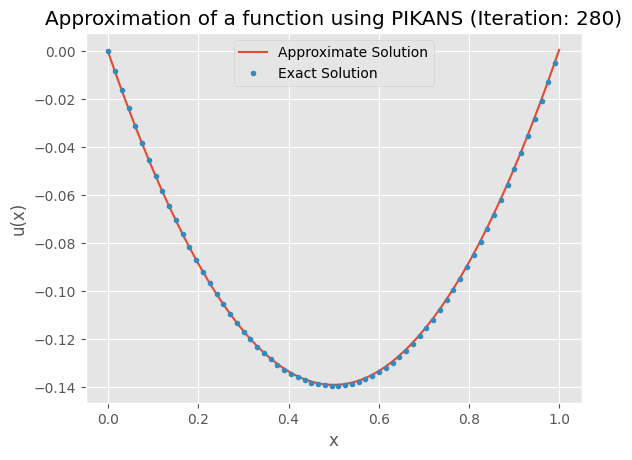

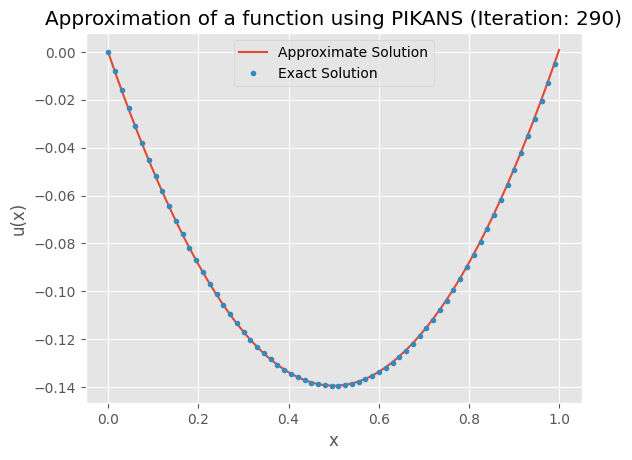

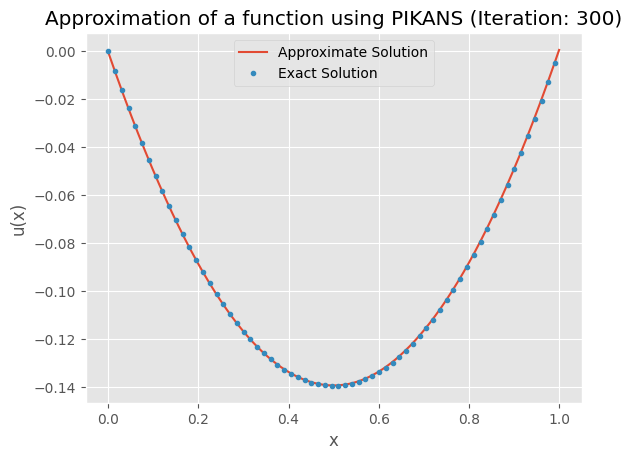

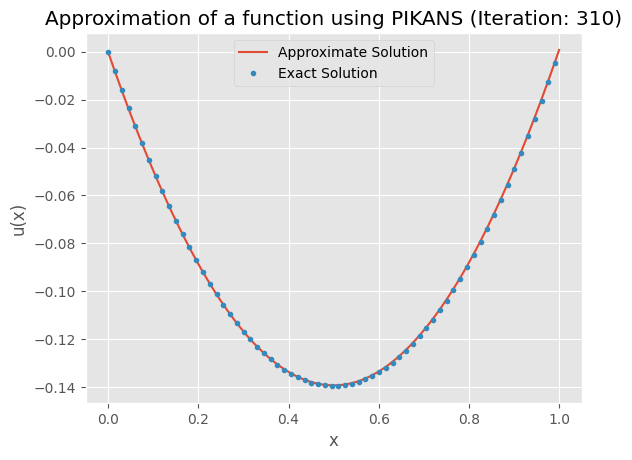

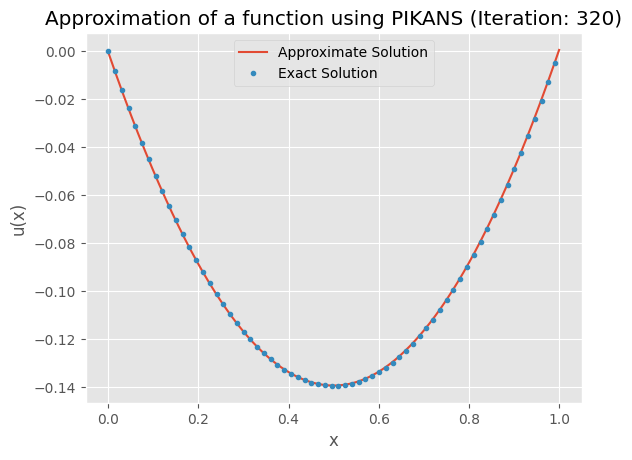

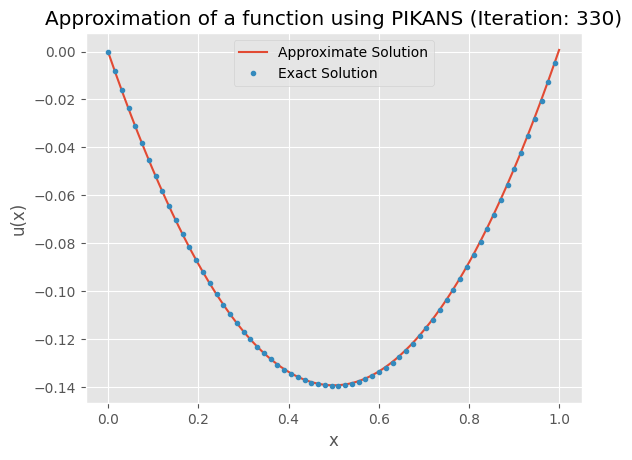

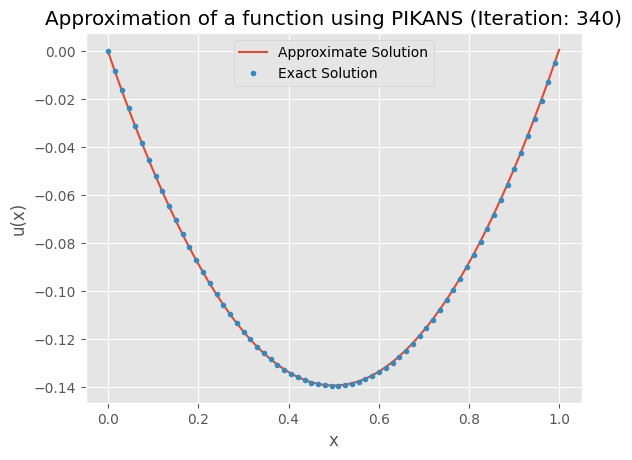

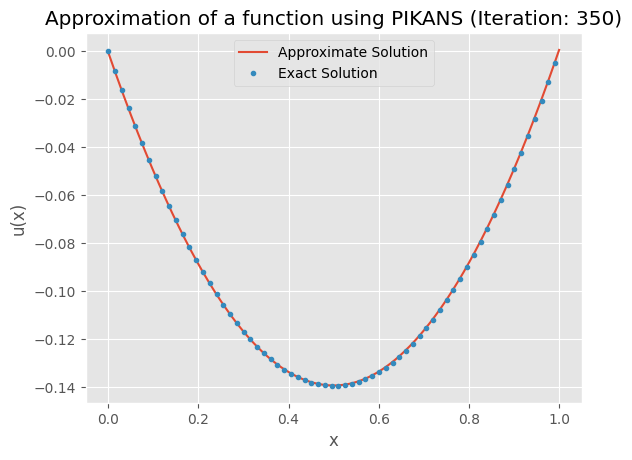

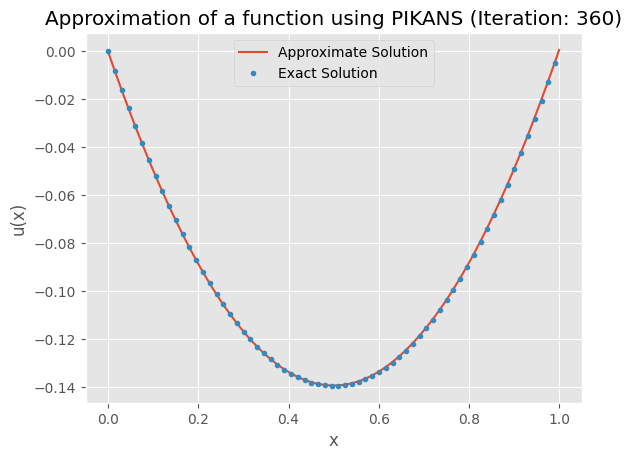

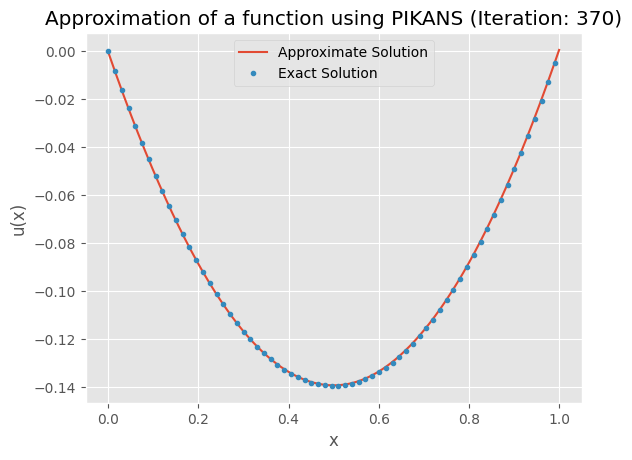

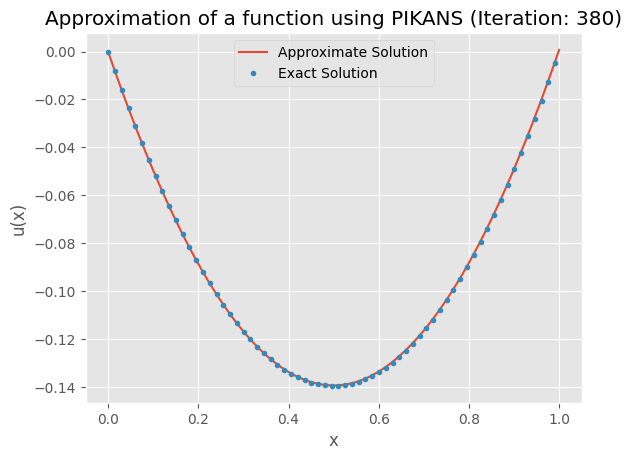

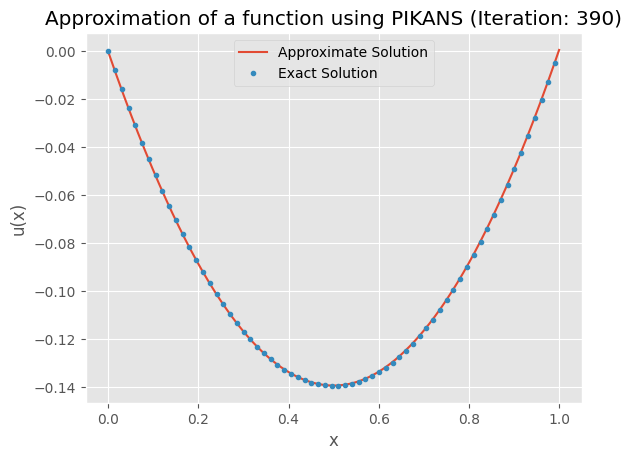

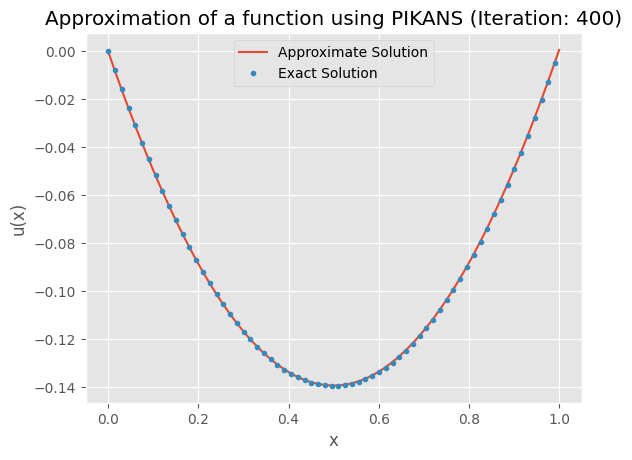

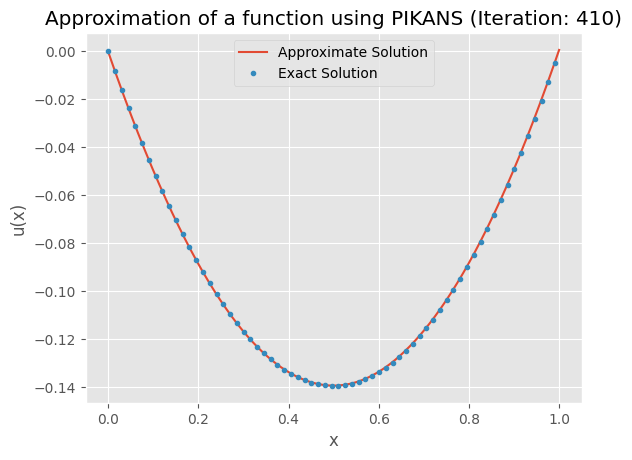

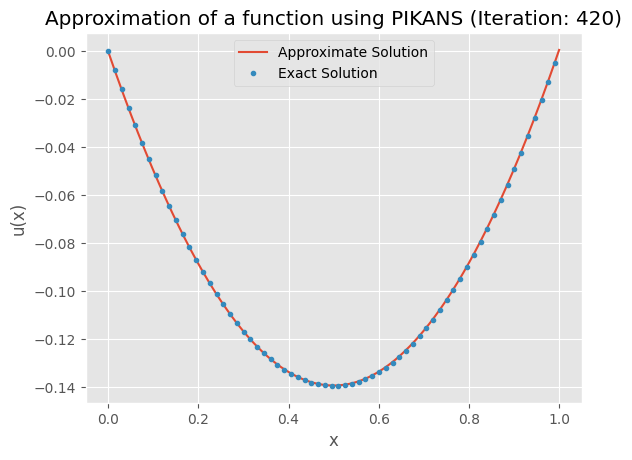

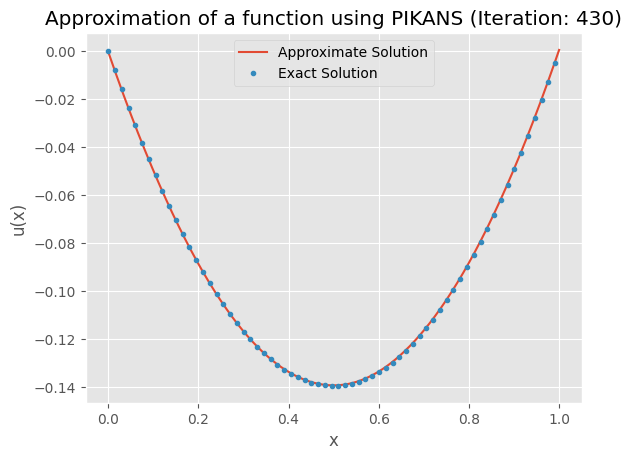

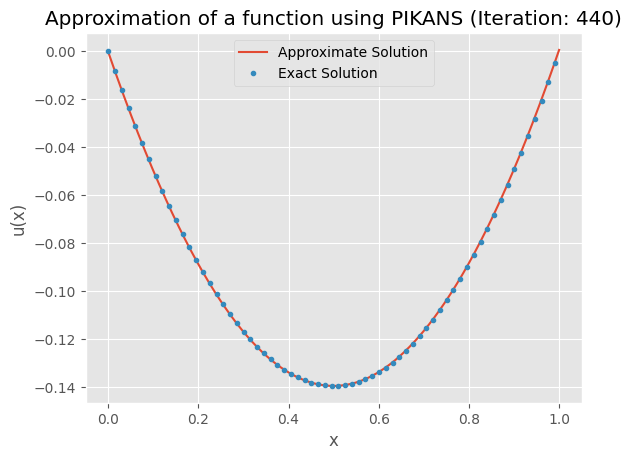

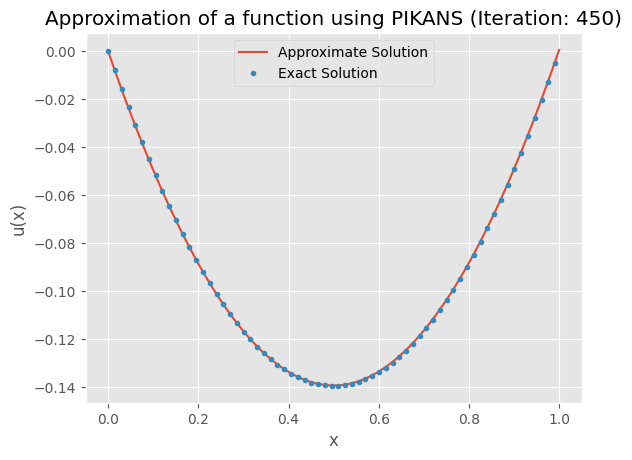

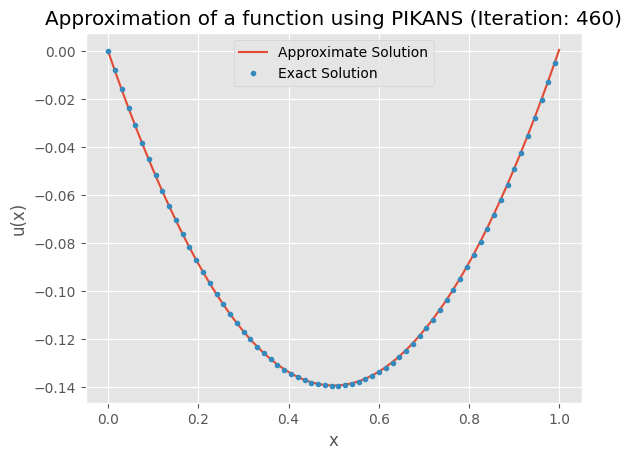

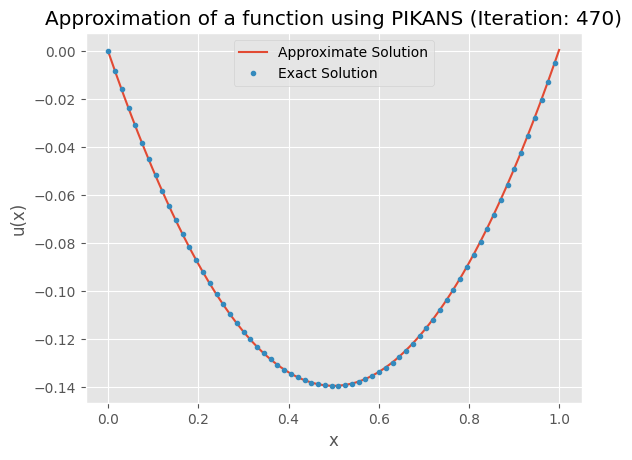

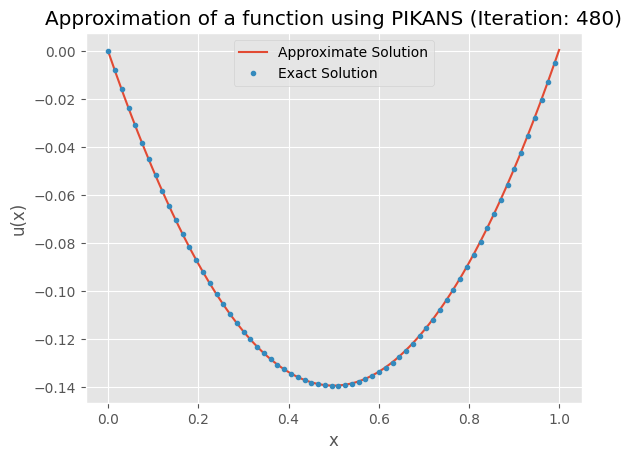

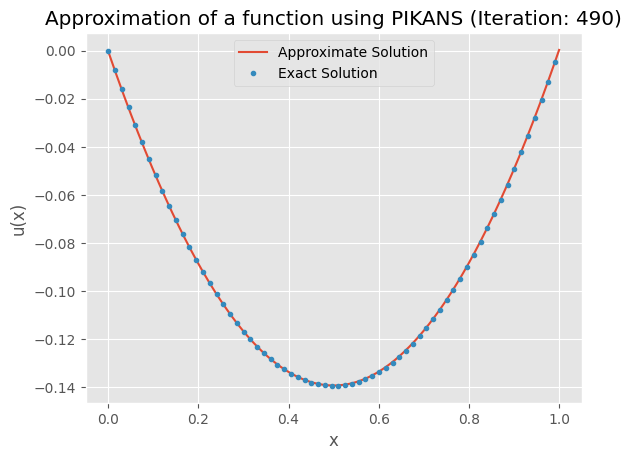

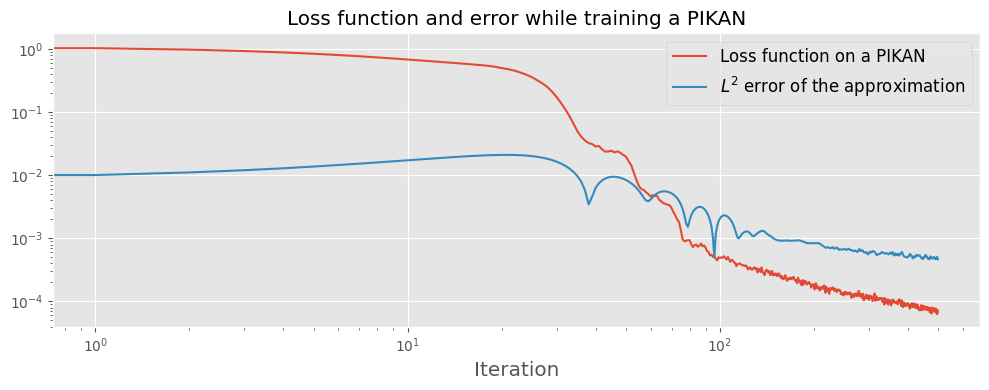

In [6]:
losses = train(model, optimizer, loss_fn, f_rhs, n_pts, iterations)

In [11]:
xlist = np.linspace(0, 1, n_pts)
xlist_torch = torch.tensor(xlist, dtype=torch.float32, requires_grad=True).view(-1, 1).to(device)

u_ap = model(xlist_torch)
u_ex = exact_u(xlist_torch)

# Move back to CPU for numpy operations if needed
u_ap = u_ap.cpu().detach().numpy()
u_ex = u_ex.cpu().detach().numpy()

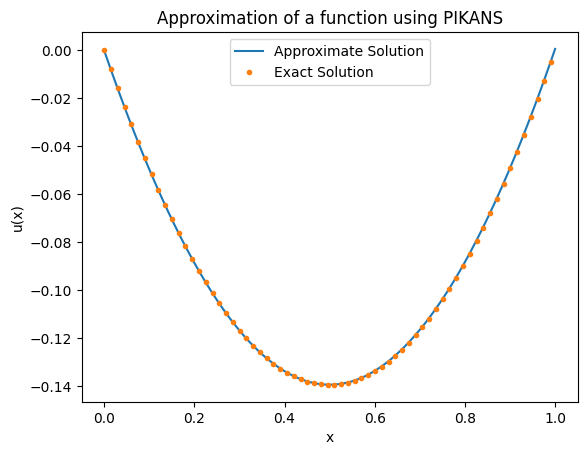

In [12]:
fig, ax = plt.subplots()
plt.plot(xlist, u_ap)
plt.plot(xlist, u_ex, ".", markevery=15)
plt.title('Approximation of a function using PIKANS')
plt.legend(['Aproximación', 'Exacta'])
plt.xlabel("x")
plt.ylabel("u(x)")
ax.legend(['Approximate Solution', 'Exact Solution'])


In [13]:

relative_error = np.mean(np.abs(u_ap -  u_ex))/ np.mean(np.abs( u_ex))
print(relative_error)

relative_error_median = np.median(np.abs(u_ap -  u_ex))/ np.median(np.abs( u_ex))
print(relative_error_median)

MSE  = np.mean((u_ap -  u_ex)**2)
print(MSE)

Numpar = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(Numpar)


0.0020129934932759407
0.0017067470203591395
4.778625849483748e-08
288


In [20]:
import os
from PIL import Image

# Directorio donde están las imágenes
image_folder = 'figures_Kan'
# Nombre del archivo de salida
gif_name = 'figures_Kan/pikan_animation.gif'

# Obtener la lista de archivos de imagen en la carpeta
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images.sort()  # Asegurarse de que están en orden alfabético

# Cargar la primera imagen para obtener su tamaño
first_image = Image.open(os.path.join(image_folder, images[0]))
first_size = first_image.size  # Obtener el tamaño de la primera imagen (ancho, alto)

# Crear lista para almacenar las imágenes redimensionadas y convertirlas al mismo modo (RGB)
frames = []
for image in images:
    img = Image.open(os.path.join(image_folder, image))
    img = img.convert("RGB")  # Convertir la imagen al modo RGB
    img = img.resize(first_size)  # Redimensionar la imagen al tamaño de la primera imagen
    frames.append(img)

# Calcular la duración por fotograma para que el GIF dure 10 segundos
total_duration = 10 * 1000  # 10 segundos en milisegundos
duration_per_frame = total_duration // len(frames)

# Guardar el gif
frames[0].save(gif_name, format='GIF', append_images=frames[1:], save_all=True, duration=duration_per_frame, loop=0)

print(f"GIF creado: {gif_name}, con duración de {duration_per_frame} ms por fotograma")

GIF creado: figures_Kan/pikan_animation.gif, con duración de 100 ms por fotograma


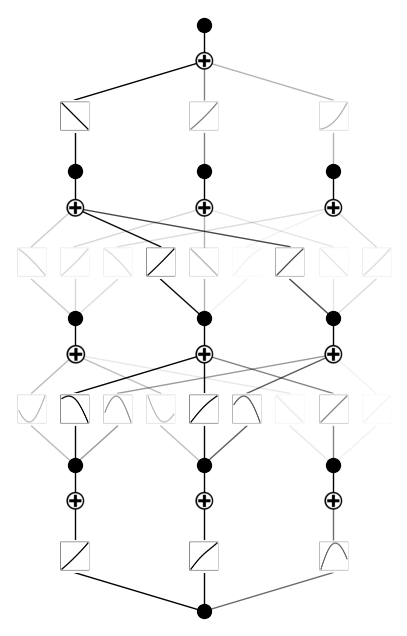

In [14]:
KANPLOT = model.plot()
plt.savefig('KAN.png', dpi=300, bbox_inches='tight')


In [18]:
from kan.utils import ex_round

ex_round(model.symbolic_formula()[0][0],5)

0

In [25]:
# Extract the symbolic formula
symbolic_expr = model.symbolic_formula()

# Refine the symbolic output, rounding to 3 decimal places (example)
refined_expr = ex_round(symbolic_expr, n_digit=5)

# Display the refined formula

[x_1]